In [1]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval

import sys
sys.path.append('../scripts')
sys.path.append('../src')

from robot_arm import RobotArm, RobotArm2D, RobotArm3D
from task_info import TaskInfo, numpy_linspace
import data_prep

from PIBB_helper import qdotdot_gen
from pdff_kinematic_sim_funcs import get_traj_and_simulate2d, get_traj
import matplotlib.pyplot as plt
from pdff_kinematic_sim_funcs import PIBB
from pdff_kinematic_sim_funcs import gen_theta
from interpolators import IDW, LinearInterpolator

# Load Data

In [2]:
data_path = '../training_data/20220327_2215_pibb_2D.csv'
task_info_path = '../training_data/20220327_2215_task_info.csv'

pibb_data_df, task_info_df = data_prep.load_data(data_path, task_info_path)

In [3]:
task_info = data_prep.task_info_from_df(task_info_df)

robot_arm = RobotArm2D(
    n_dims = 3,
    link_lengths = np.array([0.6, 0.3, 0.1])
)
task_info.robotarm = robot_arm
task_info = data_prep.clean_task_info(task_info, task_info_df)

In [4]:
concat_input, flatten_theta, holdout, original_df = data_prep.clean_data(pibb_data_df, task_info)

740
Input sizes are: 
 joint angles:  (740, 3) 
x_target:  (740, 1) 
y_target:  (740, 1)
Output size is:
 theta:  (740, 5, 3)


# Scipy Interpolation

In [13]:
SCALAR = "STD"

In [14]:
lin_interp = LinearInterpolator(concat_input, flatten_theta, d=True, scalar=SCALAR)

In [15]:
del_interp = LinearInterpolator(concat_input, flatten_theta, d=True, scalar=SCALAR)

In [16]:
nn_interp = IDW(concat_input, flatten_theta, K=1, scalar=SCALAR)
idw_interp_3 = IDW(concat_input, flatten_theta, K=3, scalar=SCALAR)
idw_interp_5 = IDW(concat_input, flatten_theta, K=5, scalar=SCALAR)

# Visualize Results

In [9]:
def get_preds_df(interpolator):
    preds_dict = {"input":[], "pred_theta":[], "theta":[]}
    for r in range(len(pibb_data_df)):
        if r%1000 == 0:
            print(r)

        pred_t = interpolator(concat_input[r])
        preds_dict["input"].append(concat_input[r])
        preds_dict["pred_theta"].append(pred_t[0])
        preds_dict["theta"].append(flatten_theta[r])
    return pd.DataFrame.from_dict(preds_dict)

In [ ]:
nn_preds = get_preds_df(nn_interp)
idw_preds = get_preds_df(idw_interp)
lin_preds = get_preds_df(lin_interp)

In [ ]:
from IPython import display

def animate_result(preds_df, result_index):

    print("input: " + str(preds_df["input"][result_index]))
    print("predicted: " + str(preds_df["pred_theta"][result_index]))
    print("actual: " + str(preds_df["theta"][result_index]))

    theta_reshaped = np.reshape(preds_df["pred_theta"][result_index], ( task_info.B, task_info.N))
    # print(theta_reshaped)

    test_input = preds_df["input"][result_index]
    target_pt = [test_input[-2], test_input[-1]]
    init_condit = [list(test_input[:3]), [0,0,0]]

    # print(target_pt)
    # print(init_condit)

    predicted_qdotdot = np.array(  
        [
            qdotdot_gen(task_info, theta_reshaped, t) for t in numpy_linspace(0, task_info.T, task_info.dt)
        ]  
        )
        
    # print(predicted_qdotdot.shape)
    time_steps, q, qdot, gen_qdotdot, ani = get_traj_and_simulate2d(
        qdotdot     = predicted_qdotdot, 
        robot_arm   = robot_arm, 
        x_goal      = target_pt, 
        init_condit = init_condit, 
        dt          = task_info.dt
        )

    video = ani.to_jshtml(fps = 60)
    # video = ani.to_html5_video() # to save as mp4, use this
    html = display.HTML(video)
    display.display(html)

### Animate Interpolator Trajectory for 5 random points from the dataset

In [ ]:
import random
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0, len(concat_input)), 5)
print(randomlist)

for r in randomlist:
    animate_result(idw_preds, r)

# Unknown Points

In [9]:
print(len(holdout))

23680


In [10]:
import math

def gen_trajectory_and_get_euclidean(interpolator, unknown_data, verbose=True):
    pred_unknown = interpolator(unknown_data)
    unknown_reshaped = pred_unknown.reshape(task_info.B, task_info.N)


    predicted_qdotdot = np.array(  
        [
            qdotdot_gen(task_info, unknown_reshaped, t) for t in numpy_linspace(0, task_info.T, task_info.dt)
        ]  
    )
        
    # print(predicted_qdotdot.shape)
    # (qdotdot, robot_arm, x_goal, init_condit, dt)
    time_steps, q, qdot, qdotdot = get_traj(
        predicted_qdotdot, 
        robot_arm, 
        dt = task_info.dt,
        init_condit = [unknown_data[0:3], [0,0,0]]
    )
    
    last_q = q[-1, :]
    reached_pt = robot_arm.forward_kinematics(last_q)
    euc_dist = np.sqrt((reached_pt[0] - unknown_data[-2])**2 + (reached_pt[1] - unknown_data[-1])**2)
    if verbose:
        print("The target pt is: {}; The robot reached {}; Euc distance is : {}".format([unknown_data[-2], unknown_data[-1]], reached_pt, euc_dist))
        print("Theta: " + str(unknown_reshaped))
        print("Data: " + str(unknown_data))
    return euc_dist

[0.10225211151778558, 0.11515946807356561, 0.122005576137083, 0.10154897385165465, 0.10154897385165465]
[500, 500, 500, 416, 416]


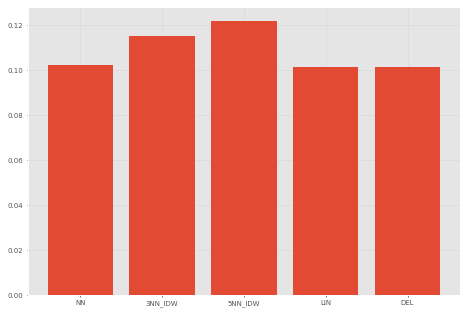

In [18]:
import random

num_configs = 1
num_points = 100

interpolation_styles = ["NN", "3NN_IDW", "5NN_IDW", "LIN", "DEL"]
interpolators = [nn_interp, idw_interp_3, idw_interp_5, lin_interp, del_interp]

totals = [0.0, 0.0, 0.0, 0.0, 0.0]
points = [0, 0, 0, 0, 0]
for i in range(5):
    randomlist = random.sample(range(0, 2440), num_configs*num_points)
    for r_id in randomlist:
        init_r = [float(angle) for angle in original_df.iloc[r_id]["init_joint_angles"][1:-1].split()]
        target_r = [original_df.iloc[r_id]["x_target"], original_df.iloc[r_id]["y_target"]]
        unknown_target = [*[*init_r, *target_r]]
        
        for i in range(len(interpolators)):
            euclid = gen_trajectory_and_get_euclidean(interpolators[i], unknown_target, verbose=False)
            if not math.isnan(euclid):
                totals[i] += euclid
                points[i] += 1
                    

avg_euclideans = [0.0, 0.0, 0.0, 0.0, 0.0]
for i in range(len(totals)):
    avg_euclideans[i] = totals[i]/points[i]

print(avg_euclideans)
print(points)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(interpolation_styles, avg_euclideans)
plt.show()


[0.7935296157235231, 0.8314683549220527, 0.8432735918430693, 0.819193182732122, 0.819193182732122]
[500, 500, 500, 429, 429]


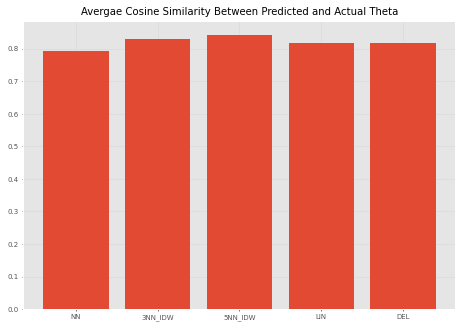

In [17]:
import random
import math
from scipy.spatial.distance import cosine

def theta_convert(str):
    ret = []
    for r in str[1:-1].split("\n"):
        ts = r.strip()[1:-1].split(" ")
        ts = [t for t in ts if t != ""]
        ts = [float(t) for t in ts]
        ret.extend(ts)
    return ret

num_configs = 1
num_points = 100

interpolation_styles = ["NN", "3NN_IDW", "5NN_IDW", "LIN", "DEL"]
interpolators = [nn_interp, idw_interp_3, idw_interp_5, lin_interp, del_interp]
strat = "SKIPS"

totals = [0.0, 0.0, 0.0, 0.0, 0.0]
points = [0, 0, 0, 0, 0]
for i in range(5):
    randomlist = random.sample(range(0, 2440), num_configs*num_points)
    for r_id in randomlist:
        init_r = [float(angle) for angle in original_df.iloc[r_id]["init_joint_angles"][1:-1].split()]
        target_r = [original_df.iloc[r_id]["x_target"], original_df.iloc[r_id]["y_target"]]
        unknown_target = [*[*init_r, *target_r]]

        for i in range(len(interpolators)):
            pred = interpolators[i](unknown_target)
            if math.isnan(pred[0]):
                continue
            original = theta_convert(original_df.iloc[r_id]["Theta"])
            dist = 1-cosine(pred, original)
            totals[i] += dist
            points[i] += 1
                    

avg_sim = [0.0, 0.0, 0.0, 0.0, 0.0]
for i in range(len(totals)):
    if points[i] == 0:
        avg_sim[i] = 0
    else:
        avg_sim[i] = totals[i]/points[i]

print(avg_sim)
print(points)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(interpolation_styles, avg_sim)
ax.set_title("Avergae Cosine Similarity Between Predicted and Actual Theta")
plt.show()


In [ ]:
idw_interp_3([2.64657515,  2.73504186, -1.55626904, 0, 0])[0]

In [ ]:
lin_interp([2.64657515,  2.73504186, -1.55626904, 0, 0])[0]

In [ ]:
nn_interp([2.64657515,  2.73504186, -1.55626904, 0, 0])[0]

In [ ]:
init_conditions = np.unique(concat_input[:, 0:3], axis=0)
print(init_conditions)

filter_condition = init_conditions[5]
filter = (concat_input[:,0] == filter_condition[0]) & (concat_input[:,1] == filter_condition[1]) & (concat_input[:,2] == filter_condition[2])
filtered = concat_input[filter]

c_xs = filtered[:, -2]
c_ys = filtered[:, -1]
plt.scatter(x=c_xs, y=c_ys)
x_goal = -0.75
y_goal = 0.4
plt.scatter(x_goal, y_goal)
plt.show()

In [ ]:
from IPython import display

def animate_traj_to_point(interpolator, input):
    theta_pred = interpolator(input)

    theta_reshaped = np.reshape(theta_pred, ( task_info.B, task_info.N))
    target_pt = [input[-2], input[-1]]
    init_condit = [list(input[:3]), [0,0,0]]

    predicted_qdotdot = np.array(  
        [
            qdotdot_gen(task_info, theta_reshaped, t) for t in numpy_linspace(0, task_info.T, task_info.dt)
        ]  
        )
        
    # print(predicted_qdotdot.shape)
    time_steps, q, qdot, gen_qdotdot, ani = get_traj_and_simulate2d(
        qdotdot     = predicted_qdotdot, 
        robot_arm   = robot_arm, 
        x_goal      = target_pt, 
        init_condit = init_condit, 
        dt          = task_info.dt
        )

    video = ani.to_jshtml(fps = 60)
    # video = ani.to_html5_video() # to save as mp4, use this
    html = display.HTML(video)
    display.display(html)

In [ ]:
x_goal, y_goal = 0.4099025974025974, -0.8449675324675323

In [ ]:
init_condit = concat_input[0][0:3]
input = [*init_condit, x_goal, y_goal]
animate_traj_to_point(nn_interp, input)
animate_traj_to_point(idw_interp_3, input)
animate_traj_to_point(idw_interp_5, input)

# Save Models

In [ ]:
np.save("interpolator_linear_rej", np.array(interp), allow_pickle=True)

In [ ]:
interp_loaded = np.load("interpolator.npy", allow_pickle=True)

In [ ]:
interp_loaded = interp_loaded.item()